### Load file & Max Duration

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('C:/Users/noahc/Desktop/CCS_CALLS_EQUATURE.csv')

df = pd.DataFrame(data)
df['Name'] = df['Name'].replace({64000: "Emergency Line", 63473: "Main Police Line", 66465: "Champlain College Line", 63474: "Backup Police Line", 64444: "Rescue Line"})

df.Duration.max()
df

,Name,Date,Time,Duration (Milliseconds),Duration
0,Emergency Line,6/1/2024,4:41,11392,0m 11.39s
1,Main Police Line,6/1/2024,6:00,31488,0m 31.49s
2,Main Police Line,6/1/2024,6:29,9984,0m 9.98s
3,Main Police Line,6/1/2024,11:44,83328,1m 23.33s
4,Main Police Line,6/1/2024,12:32,26752,0m 26.75s
...,...,...,...,...,...
29243,Main Police Line,6/30/2025,22:34,7296,0m 7.3s
29244,Main Police Line,6/30/2025,22:35,3968,0m 3.97s
29245,Main Police Line,6/30/2025,23:06,65408,1m 5.41s
29246,Champlain College Line,6/30/2025,23:13,22144,0m 22.14s


### Min duration

In [2]:
df.Duration.min()

'0m 0.13s'

### Clean Outliers

In [3]:
outliersAbove = df["Duration (Milliseconds)"].quantile(0.99)
outliersBelow = df["Duration (Milliseconds)"].quantile(0.01)
df = df[(df["Duration (Milliseconds)"] < outliersAbove) & (df["Duration (Milliseconds)"] > outliersBelow)]
df.Duration.min()


'0m 0.9s'

### Average time of call in seconds

In [4]:
res = (df["Duration (Milliseconds)"] / 1000).mean()
str(int(res)) + " seconds"

'39 seconds'

### Average duration per call per Name code

In [5]:
df_group = df.groupby("Name")["Duration (Milliseconds)"].mean() / 1000
df_group = df_group.to_frame()
df_group.sort_values("Duration (Milliseconds)", ascending = False)

,Duration (Milliseconds)
Name,
Main Police Line,43.008191
Emergency Line,38.189000
Champlain College Line,35.170974
Backup Police Line,28.545956
Rescue Line,24.158638


## Percentage of call time per Name

In [16]:
df_group = df.groupby("Name")["Duration (Milliseconds)"].sum() / (1000 * 60 * 60)
df_group.rename({"Duration (Milliseconds)": "Hours"})
frame = df_group.to_frame().reset_index()
sumation = 0
for key in df_group.keys():
    sumation += df_group[key]
sumation = int(sumation)
df_group_wpercentage = {}
for key in df_group.keys():
    perc = df_group[key] / sumation
    df_group_wpercentage[key] = float(perc) * 100
temp = {"Name": df_group_wpercentage.keys(), 
        "Duration (Milliseconds)": df_group_wpercentage.values()}
#Create and Merge tables
perc_frame = pd.DataFrame(temp)
new_frame = pd.merge(frame, perc_frame, on="Name")
new_frame = new_frame.rename(columns={'Duration (Milliseconds)_x': 'Total Hours', 'Duration (Milliseconds)_y': 'Percent Of Total'})
new_frame.sort_values("Percent Of Total", ascending=False)

,Name,Total Hours,Percent Of Total
3,Main Police Line,244.408678,70.638346
1,Champlain College Line,63.918449,18.473540
2,Emergency Line,17.650353,5.101258
0,Backup Police Line,16.662242,4.815677
4,Rescue Line,3.630506,1.049279


### Pie Chart Creation

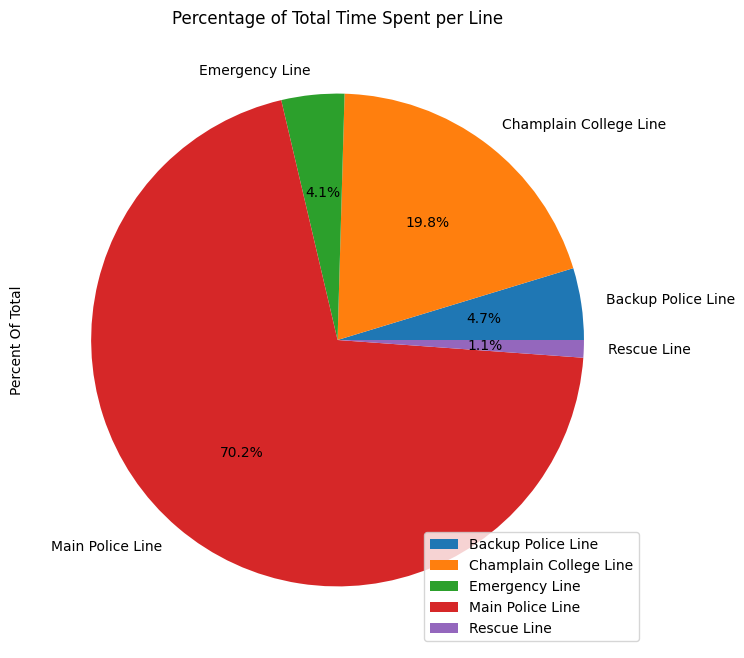

In [7]:
plot = new_frame.plot.pie(y="Percent Of Total", labels=new_frame['Name'], autopct='%1.1f%%', title="Percentage of Total Time Spent per Line", figsize=(8,8))
plot.legend(loc="lower right")

### Grouped by Name & Month, Averages

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
group_months = df.groupby([df["Date"].dt.month, df["Name"]])["Duration (Milliseconds)"].sum().reset_index()


group_months["Duration (Seconds)"] = group_months["Duration (Milliseconds)"] / 1000
group_months = group_months.drop(columns="Duration (Milliseconds)")


group_months_mean_hours = df.groupby([df["Date"].dt.month, df["Name"]])["Duration (Milliseconds)"].mean().reset_index()
group_months_mean_hours["Duration (Milliseconds)"] = group_months_mean_hours["Duration (Milliseconds)"] / 1000
group_months_mean_hours = group_months_mean_hours.rename(columns={"Duration (Milliseconds)": "Mean Duration (Seconds)"})
group_months_mean_hours["Mean Duration (Hours)"] = group_months_mean_hours["Mean Duration (Seconds)"] / 60 / 60

group_months["Duration (Hours)"] = group_months["Duration (Seconds)"] / 60 / 60

group_months_merge = pd.merge(group_months, group_months_mean_hours, on=["Name", "Date"])
temp = group_months_merge.pivot(index = "Date", columns = "Name", values = "Duration (Seconds)")

### Plot Sum Duration (Seconds)

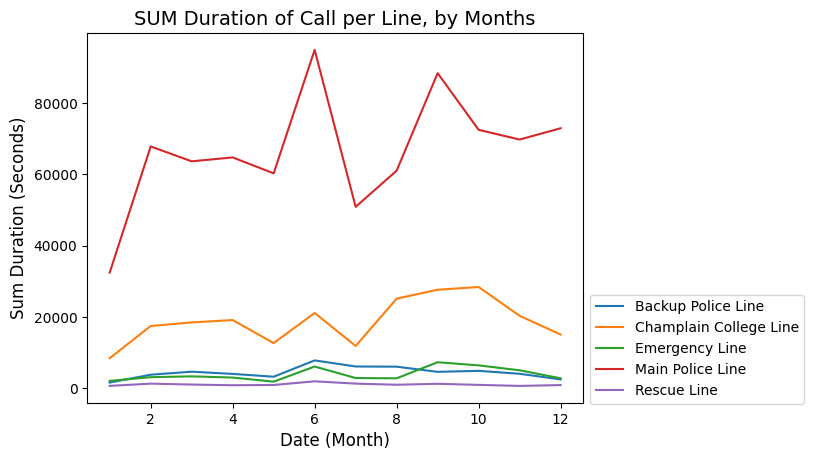

In [9]:
line_plot = temp.plot()
line_plot.set_xlabel("Date (Month)", fontsize=12)
line_plot.set_ylabel("Sum Duration (Seconds)", fontsize=12)
line_plot.set_title("SUM Duration of Call per Line, by Months", fontsize=14)
line_plot.legend(loc="center left", bbox_to_anchor=(1.0, 0.145))


### Plot Mean Duration (Seconds)

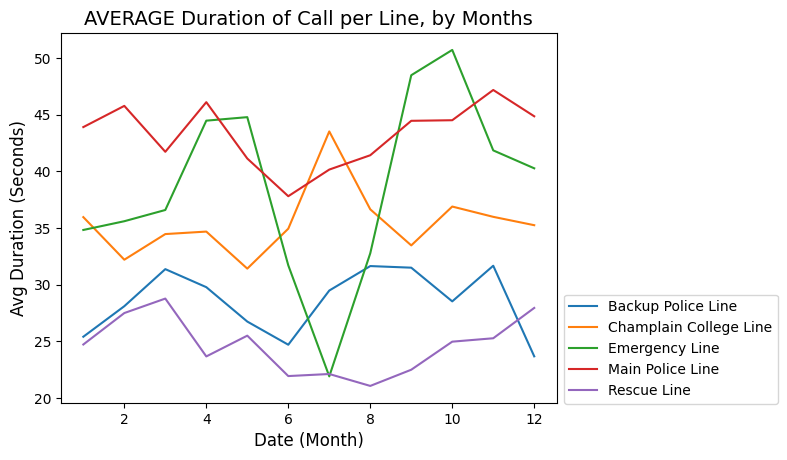

In [10]:
temp = group_months_merge.pivot(index = "Date", columns = "Name", values = "Mean Duration (Seconds)")
line_plot = temp.plot()
line_plot.set_xlabel("Date (Month)", fontsize=12)
line_plot.set_ylabel("Avg Duration (Seconds)", fontsize=12)
line_plot.set_title("AVERAGE Duration of Call per Line, by Months", fontsize=14)
line_plot.legend(loc="center left", bbox_to_anchor=(1.0, 0.145))

### Bar Chart to represent Champlain consistency

Text(0.5, 1.0, 'Average Duration per Line, by Month')

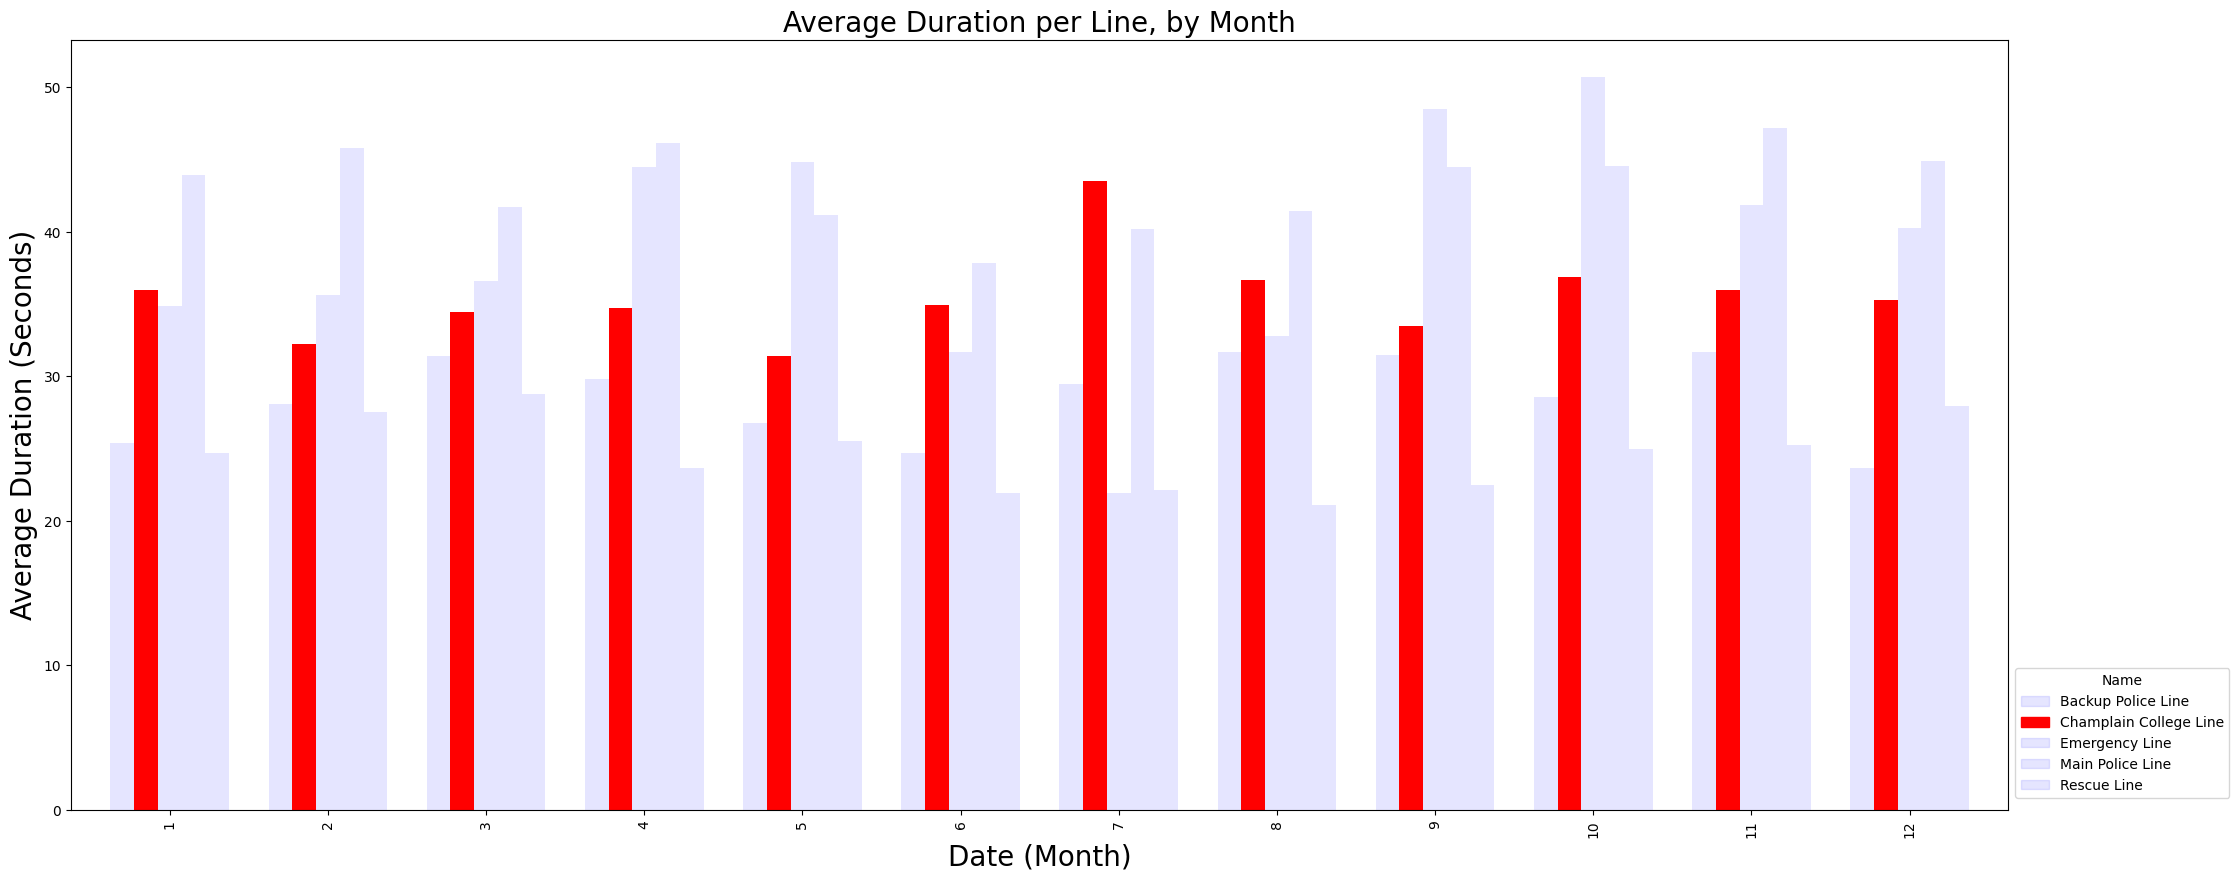

In [11]:
bar_plot = temp.plot(kind="bar", width=0.75, figsize=(25,10))
for i, bar in enumerate(bar_plot.patches):
    label = bar_plot.get_legend().get_texts()[i // len(temp.index)].get_text()
    if label == "Champlain College Line":
        bar.set_alpha(1.0)
        bar.set_facecolor("red")
    else:
        bar.set_alpha(0.1)
        bar.set_facecolor("blue")
import matplotlib.patches as mpatches
legend_handles = []
for name in temp.columns:
    if name == "Champlain College Line":
        patch = mpatches.Patch(color="red", label=name, alpha=1.0)
    else:
        patch = mpatches.Patch(color="blue", label=name, alpha=0.1)
    legend_handles.append(patch)
    
bar_plot.legend(handles=legend_handles, title="Name", loc="center left", bbox_to_anchor=(1.0, 0.1))
bar_plot.set_xlabel("Date (Month)", fontsize=20)
bar_plot.set_ylabel("Average Duration (Seconds)", fontsize=20)
bar_plot.set_title("Average Duration per Line, by Month", fontsize=20)

# Start Exporting

In [12]:
#temp.to_csv('C:/Users/noahc/Desktop/average_duration_per_month.csv', index=False)
#group_months_merge.to_csv('C:/Users/noahc/Desktop/average_duration_per_category.csv', index=False)
#new_frame.to_csv('C:/Users/noahc/Desktop/percent_and_total.csv', index=False)